# Convolutional Neural Net

Convolutional Neural Networks (CNN) are - besides Transformers - the most popular type of neural nets used for images.

CNNs enable image classification by repeatedly applying convolution operations mapping the ~1 mio. pixels to the predicted tensor.

<p>
<img src="https://www.louisbouchard.ai/content/images/size/w2000/2021/04/1_QPRC1lcfYxcWWPAC2hrQgg.gif"/>
<figcaption>Taken from <a href="https://halil7hatun.medium.com/convolutional-neural-networks-cnns-95321b1f63ff">https://halil7hatun.medium.com/convolutional-neural-networks-cnns-95321b1f63ff</a></figcaption>
</p>

## 1. Convolution
### What does a convolution do?

Convolutions can be thought of as image filters.

To get a visual understand (chill, no math) let's start with an example image from the MNIST dataset

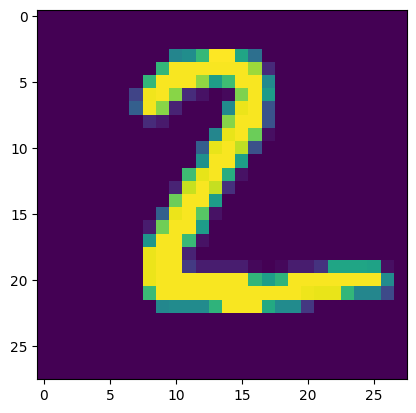

In [ ]:
#@title Plot a 2 from MNIST
import pandas as pd
import matplotlib.pyplot as plt

mnist = pd.read_csv('sample_data/mnist_test.csv')
mnist_pixels = mnist.iloc[:, 1:]
mnist_images = mnist_pixels.values.reshape(-1, 28, 28)
plt.imshow(mnist_images[0]);

For beginners, it's actually not that important to understand the math behind convolutions. But if you still insist just look at this [GIF](https://en.wikipedia.org/wiki/Kernel_%28image_processing%29#/media/File:2D_Convolution_Animation.gif).

A convolution uses a kernel - a small array - e.g.

```python
kernel = [[-1., -1., -1.],
          [0., 0., 0.],
          [1., 1., 1.]]

```
which is applied to every pixel of the input image.

To get a feeling for what that does, let's apply the above kernel 4 times, each time rotating the kernel by 90 degrees

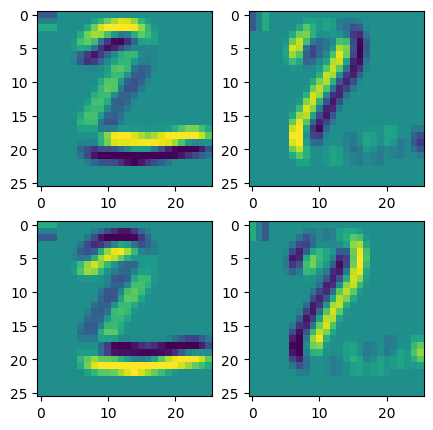

In [ ]:
#@title 2 filtered with kernel (showed in top left of each image)
import torch
import numpy as np
import torch.nn as nn

kernel = [[-1., -1., -1.],
          [0., 0., 0.],
          [1., 1., 1.]]
conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3)
conv.weight.requires_grad = False
conv.bias.requires_grad = False
image = (mnist_images[0] / 255.).astype(np.float32)
image = torch.from_numpy(image)

filtered_images = []
f, axs = plt.subplots(2, 2, figsize=(5, 5))
for i, ax in enumerate(axs.flatten()):
  conv.weight.data[0, 0] = torch.tensor(kernel).rot90(i)
  filtered_image = conv(image[None, None])[0, 0]
  filtered_images.append(filtered_image.clone())
  filtered_image[:3, :3] = conv.weight.data[0, 0]
  ax.imshow(filtered_image)#, vmin=-1, vmax=1)

You can see that along the direction
- where kernel values change -> edges are amplified
- where kernel values do not change -> edges are reduced

Before machine learning was popular detecting edges was one of the first steps in rules-based character recognition software.

Being a developer during that time I would think:

- "Ok, just think of some more useful kernels and use the filtered images + some rules to classify the 10 digits"

Being a developer now I think:

- "Ok, just apply some random kernels and let Autograd 🦮 guide the values in the kernels towards optimal digit classification"

The second approach 🦮 is
- much simpler

and as it turns out
- leads to better results

as described by one of the godfathers of artifical intelligence in [The Bitter Lesson](http://www.incompleteideas.net/IncIdeas/BitterLesson.html).

In the GIF at the top of this chapter you can see where the second approach leads us and how well it works.

<p>
<img src="https://images.contentstack.io/v3/assets/blt71da4c740e00faaa/blt00144f36f1d54bb0/6012005796de49101cfb58db/meme-moneyprinter-bitterlesson-gpt3.png" width=800/>
<figcaption>Taken from <a href="https://horace.io/brrr_intro.html">https://horace.io/brrr_intro.html</a></figcaption>
</p>

### `nn.Conv3d`

As we are working with 3D images we will concentrate on 3D operations from here on out.

PyTorch provides convolution operations instantiated with

```python
import torch.nn as nn

conv_3d = nn.Conv3d(in_channels=1, out_channels=4, kernel_size=3)
```
which can be applied to a 5D tensor `x` via
```python
x_out = conv_3d(x)
```
You might ask "Why 5D?". All `nn.Conv` operations expect the input tensors to have two dimensions preceding the actual spatial dimensions:
1. batch dimension - Stacking samples along this dimension allows parallel processing (see 5_PyTorch, 4. DataLoader)
2. channel dimensions - Stacking samples along this dimension allows the convolution to incorporate multiple images (e.g. RGB - red, green, blue - channels)

To understand this solve the following tasks:

**Task 1.1:** Create a torch (input-) tensor with shape `(1, 1, 128, 128, 128)`.

In [ ]:
import torch

x = torch.rand(1, 1, 128, 128, 128)

**Task 1.2:** Apply the `conv_3d` to the created input tensor and print the shape of the output tensor.

In [ ]:
import torch.nn as nn

conv_3d = nn.Conv3d(in_channels=1, out_channels=4, kernel_size=3)
x_out = conv_3d(x)
print(x_out.shape)

torch.Size([1, 4, 126, 126, 126])


**Task 1.3:** Change `in_channels`, `out_channels` and the shape of the first two dimensions of the input tensor and see how it affects the output tensor shape

In [ ]:
conv_3d = nn.Conv3d(in_channels=1, out_channels=4, kernel_size=3)
x_out = conv_3d(x)
print(x_out.shape)

torch.Size([1, 4, 126, 126, 126])


In [ ]:
conv_3d = nn.Conv3d(in_channels=1, out_channels=6, kernel_size=3)
x_out = conv_3d(x)
print(x_out.shape)

torch.Size([1, 6, 126, 126, 126])


In [ ]:
conv_3d = nn.Conv3d(in_channels=2, out_channels=6, kernel_size=3)
x_out = conv_3d(x)
print(x_out.shape)

RuntimeError: Given groups=1, weight of size [6, 2, 3, 3, 3], expected input[1, 1, 128, 128, 128] to have 2 channels, but got 1 channels instead

In [ ]:
x = torch.rand(1, 2, 128, 128, 128)
conv_3d = nn.Conv3d(in_channels=2, out_channels=6, kernel_size=3)
x_out = conv_3d(x)
print(x_out.shape)

torch.Size([1, 6, 126, 126, 126])


**Resource for advanced scholars**: To understand how `nn.Conv2d` *really* handles channel dimensions watch [this video](https://www.youtube.com/watch?v=w4kNHKcBGzA&ab_channel=AnimatedAI).

## 2. Pooling

### What does pooling do?

Poolings - like convolutions - can also be thought of as image filters.

Pooling reduces the size while keeping the most significant information of its input by

1. dividing it into a set of non-overlapping rectangles/kernels
2. applying an operation which returns one pixel value for each rectangle

In the following you see the filtered images (from chapter 1) pooled with
1. a kernel size of 3x3: input gets divided into 3x3 rectangles
2. a maximum operation: each rectangle gets replaced with its respective maximum value

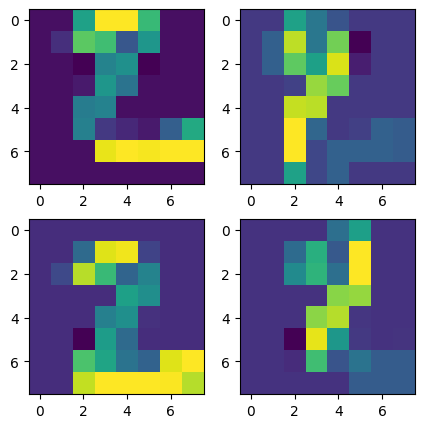

In [ ]:
#@title Convolution filtered + pooled 2s
import numpy as np

max_pool = nn.MaxPool2d(kernel_size=3)

f, axs = plt.subplots(2, 2, figsize=(5, 5))
for i, ax in enumerate(axs.flatten()):
  image = filtered_images[i]
  pooled_image = max_pool(image[None, None])[0, 0]
  ax.imshow(pooled_image)

To the human eye, the "keeping the most significant information of its input"-part is not really visible but trust me, it works 🤓

The repeated application of pooling (and convolution) *compresses* large images into the prediction tensor 🗜️

## `nn.MaxPool3d`

Again, as we are working with 3D images we will concentrate on 3D operations.

Max pooling is instantiated with

```python
import torch.nn as nn

pool_3d = nn.MaxPool3d(kernel_size=3)
```
and is applied to a 5D tensor `x` via
```python
x_out = pool_3d(x)
```

**Task 2:** Repeat Tasks 1.1-1.3
- using `nn.MaxPool3d` instead of `nn.Conv3d` and
- changing the `kernel_size` instead of `in_channels` and `out_channels`.

In [ ]:
import torch
import torch.nn as nn

x = torch.rand(1, 1, 128, 128, 128)
pool_3d = nn.MaxPool3d(kernel_size=4)
x_out = pool_3d(x)
print(x_out.shape)

torch.Size([1, 1, 32, 32, 32])


## 3. Neural Net: A Sequence of Operations

Let's again have a look at the GIF from the beginning.

The "Input" image becomes
- "Convolutional Layer 1": 6 filtered small images then
- "Convolutional Layer 2": 24 filtered smaller images then
- "Convolutional Layer 3": 96 filtered tiny images - i.e. pixels - then
- "Dense Layer 1": 128 pixels, values, numbers (?) then
- "Output Layer": 10 numbers representing the nets prediciton probability for the 10 digits

And that is **not an oversimplification: Neural nets are just operations chained together** 🤯

<p>
<img src="https://www.louisbouchard.ai/content/images/size/w2000/2021/04/1_QPRC1lcfYxcWWPAC2hrQgg.gif"/>
<figcaption>Taken from <a href="https://halil7hatun.medium.com/convolutional-neural-networks-cnns-95321b1f63ff">https://halil7hatun.medium.com/convolutional-neural-networks-cnns-95321b1f63ff</a></figcaption>
</p>

### `nn.Sequential`

As shown in the above GIF, neural nets are just a bunch of operations applied sequentially - one after the other - to an input.

The short way to build a neural net - i.e. the sequence of operations - is using `nn.Sequential`
```python
import torch.nn as nn

neural_net = nn.Sequential(nn.Conv3d(1, 4, kernel_size=3),
                           nn.MaxPool3d(kernel_size=3),
                           nn.Conv3d(4, 16, kernel_size=3),
                           nn.MaxPool3d(kernel_size=3))
```
and then applying it via
```python
x_out = neural_net(x)
```

### `nn.Module`

The longer but **more graceful way** to build a neural net is using `nn.Module`
```python
import torch.nn as nn

class NeuralNet(nn.Module):
  def __init__(self, kernel_size=3):
    super().__init__()
    self.conv1 = nn.Conv3d(1, 4, kernel_size=kernel_size)
    self.pool1 = nn.MaxPool3d(kernel_size=kernel_size)
    self.conv2 = nn.Conv3d(4, 16, kernel_size=kernel_size)
    self.pool2 = nn.MaxPool3d(kernel_size=kernel_size)

  def forward(self, x):
    x = self.conv1(x)
    x = self.pool1(x)
    x = self.conv2(x)
    x = self.pool2(x)
    return x

neural_net = NeuralNet(kernel_size=5)
```
which then also can be applied via
```python
x_out = neural_net(x)
```

This approach allows you to directly modify what is happening when an input is passed to the neural net via the `forward` method.

**Task 3.1:** Create a torch (input-) tensor with shape `(1, 1, 128, 128, 128)` containing random values.

In [ ]:
import torch

x = torch.rand(1, 1, 128, 128, 128)

**Task 3.2:** Create a neural net (in a graceful way 😉) and apply it to the input tensor.

In [ ]:
import torch.nn as nn

class NeuralNet(nn.Module):
  def __init__(self, kernel_size=3):
    super().__init__()
    self.conv1 = nn.Conv3d(1, 4, kernel_size=kernel_size)
    self.pool1 = nn.MaxPool3d(kernel_size=kernel_size)
    self.conv2 = nn.Conv3d(4, 16, kernel_size=kernel_size)
    self.pool2 = nn.MaxPool3d(kernel_size=kernel_size)

  def forward(self, x):
    x = self.conv1(x)
    x = self.pool1(x)
    x = self.conv2(x)
    x = self.pool2(x)
    return x

neural_net = NeuralNet(kernel_size=3)

x_out = neural_net(x)
print(x_out.shape)

torch.Size([1, 16, 13, 13, 13])


# Exercise

## 🚨 Warning 🚨

This Notebook builds on 1_Introduction and the exercise of 2_Data_Exploration and 4_Preprocessing.

You have to run these Notebooks (if you didn't already) and mount your Google Drive to this Notebook via
```python
from google.colab import drive
drive.mount('/content/drive')
```
then you are ready to go!

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


1. Create a neural net which given a tensor with shape `(1, 1, 128, 128, 128)` produces a tensor with shape `(1, 1, 1, 1, 1)`.

**Hint**: Think *deeply* 🤓

In [ ]:
import torch.nn as nn

class NeuralNet(nn.Module):
  def __init__(self, kernel_size=3):
    super().__init__()
    self.conv1 = nn.Conv3d(1, 4, kernel_size=kernel_size)
    self.pool1 = nn.MaxPool3d(kernel_size=kernel_size)
    self.conv2 = nn.Conv3d(4, 16, kernel_size=kernel_size)
    self.pool2 = nn.MaxPool3d(kernel_size=kernel_size)
    self.conv3 = nn.Conv3d(16, 32, kernel_size=kernel_size)
    self.pool3 = nn.MaxPool3d(kernel_size=kernel_size)
    self.conv4 = nn.Conv3d(32, 1, kernel_size=kernel_size)

  def forward(self, x):
    x = self.conv1(x)
    x = self.pool1(x)
    x = self.conv2(x)
    x = self.pool2(x)
    x = self.conv3(x)
    x = self.pool3(x)
    x = self.conv4(x)
    return x

neural_net = NeuralNet(kernel_size=3)

x = torch.rand(1, 1, 128, 128, 128)
x_out = neural_net(x)
print(x_out.shape)

torch.Size([1, 1, 1, 1, 1])


2. Using the exercise solution of 5_PyTorch create a DataLoader where the loaded Niftis have the shape `(1, 1, 128, 128, 128)`.

**Hint**: Torch functional - imported via `import torch.nn.functional as F` - provides resizing via `x = F.interpolate(x, size=...)`.

In [ ]:
import torch
import numpy as np
import nibabel as nib
import torch.nn.functional as F

class NiftiDataset(torch.utils.data.Dataset):
    def __init__(self, filepaths, age_array, size=(128, 128, 128)):
        self.niftis = [self.load_nifti(fpath, size) for fpath in filepaths]
        self.ages = torch.from_numpy(age_array)

    def __len__(self):
        return len(self.niftis)

    def __getitem__(self, idx):
        return self.niftis[idx], self.ages[idx].float()

    @staticmethod
    def load_nifti(filepath, size):
      img = nib.load(filepath)
      img = nib.as_closest_canonical(img)
      x = img.get_fdata(dtype=np.float32)
      x = torch.from_numpy(x)
      x = x[None, None]  # added 2 dimensions using [None, None] to make it 5D
      x = F.interpolate(x, size=size)  # resized it to (1, 1, 128, 128, 128)
      return x[0]  # Removed one dimension using [0] because DataLoader will add one later

In [ ]:
import pandas as pd
PATH = '/content/drive/MyDrive/openneuro'

df = pd.read_csv(f'{PATH}/dataframe_after_preprocessing.csv', index_col=0)
ds = NiftiDataset(df.zscore_filepath, age_array=df.age.values)
dl = torch.utils.data.DataLoader(ds, batch_size=1, shuffle=True)

In [ ]:
for batch in dl:
  x, y = batch
  print(x.shape, y.shape)

torch.Size([1, 1, 128, 128, 128]) torch.Size([1])
torch.Size([1, 1, 128, 128, 128]) torch.Size([1])
torch.Size([1, 1, 128, 128, 128]) torch.Size([1])
torch.Size([1, 1, 128, 128, 128]) torch.Size([1])
torch.Size([1, 1, 128, 128, 128]) torch.Size([1])
torch.Size([1, 1, 128, 128, 128]) torch.Size([1])
torch.Size([1, 1, 128, 128, 128]) torch.Size([1])
torch.Size([1, 1, 128, 128, 128]) torch.Size([1])
torch.Size([1, 1, 128, 128, 128]) torch.Size([1])
torch.Size([1, 1, 128, 128, 128]) torch.Size([1])
torch.Size([1, 1, 128, 128, 128]) torch.Size([1])
torch.Size([1, 1, 128, 128, 128]) torch.Size([1])
torch.Size([1, 1, 128, 128, 128]) torch.Size([1])
torch.Size([1, 1, 128, 128, 128]) torch.Size([1])
torch.Size([1, 1, 128, 128, 128]) torch.Size([1])
torch.Size([1, 1, 128, 128, 128]) torch.Size([1])


3. Apply each loaded Nifti to the neural network and print the output tensor next to the respective age.

In [ ]:
for batch in dl:
  x, y = batch
  x_out = neural_net(x)
  print(y, x_out)

tensor([22.]) tensor([[[[[0.0455]]]]], grad_fn=<ConvolutionBackward0>)
tensor([21.]) tensor([[[[[0.0442]]]]], grad_fn=<ConvolutionBackward0>)
tensor([24.]) tensor([[[[[0.0960]]]]], grad_fn=<ConvolutionBackward0>)
tensor([30.]) tensor([[[[[0.1379]]]]], grad_fn=<ConvolutionBackward0>)
tensor([26.]) tensor([[[[[0.0818]]]]], grad_fn=<ConvolutionBackward0>)
tensor([24.]) tensor([[[[[0.1549]]]]], grad_fn=<ConvolutionBackward0>)
tensor([26.]) tensor([[[[[0.0729]]]]], grad_fn=<ConvolutionBackward0>)
tensor([22.]) tensor([[[[[0.0629]]]]], grad_fn=<ConvolutionBackward0>)
tensor([21.]) tensor([[[[[0.1740]]]]], grad_fn=<ConvolutionBackward0>)
tensor([24.]) tensor([[[[[0.0181]]]]], grad_fn=<ConvolutionBackward0>)
tensor([24.]) tensor([[[[[0.0722]]]]], grad_fn=<ConvolutionBackward0>)
tensor([19.]) tensor([[[[[0.0441]]]]], grad_fn=<ConvolutionBackward0>)
tensor([26.]) tensor([[[[[0.0884]]]]], grad_fn=<ConvolutionBackward0>)
tensor([20.]) tensor([[[[[0.0804]]]]], grad_fn=<ConvolutionBackward0>)
tensor